In [1]:
from pycaret.regression import RegressionExperiment
from pycaret.classification import ClassificationExperiment
import pandas as pd
from tqdm import tqdm

In [3]:
# data = pd.read_csv('../Datasets/68071.csv')
# target_column = 'income'
model_name = 'adult'
exp = ClassificationExperiment()

In [4]:
exp.setup(data, target=target_column, session_id=123)

,Description,Value
0,Session id,123
1,Target,income
2,Target type,Binary
3,Target mapping,"<=50K: 0, >50K: 1"
4,Original data shape,"(48842, 15)"
5,Transformed data shape,"(48842, 67)"
6,Transformed train set shape,"(34189, 67)"
7,Transformed test set shape,"(14653, 67)"
8,Ordinal features,1
9,Numeric features,6


In [5]:
exp.create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8017,0.6288,0.2800,0.7201,0.4032,0.3109,0.3609
1,0.7967,0.8309,0.3545,0.6346,0.4549,0.3421,0.3640
2,0.7988,0.5719,0.2555,0.7257,0.3779,0.2894,0.3458
3,0.8049,0.6175,0.2787,0.7475,0.4061,0.3173,0.3729
4,0.7970,0.6027,0.2592,0.7067,0.3792,0.2878,0.3398
5,0.8005,0.6340,0.2604,0.7345,0.3845,0.2964,0.3534
6,0.7991,0.5716,0.2653,0.7162,0.3872,0.2961,0.3486
7,0.7964,0.5653,0.2482,0.7148,0.3684,0.2796,0.3355
8,0.7938,0.5578,0.2552,0.6875,0.3722,0.2787,0.3279


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
exp.get_config('X_train').columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [6]:
from tqdm.notebook import trange, tqdm
import subprocess
# import sys 
# sys.path.append('/home/ayush/BTP-2/backend/')
# import trainModelAutoML
process = subprocess.Popen(['python3', '/home/ayush/BTP-2/backend/functions/trainModelAutoML.py'], stdout=subprocess.PIPE)

while True:
    output = process.stdout.readline()
    # print(output)
    if output.decode('utf-8') == '' and process.poll() is not None:
        break
    if output:
        print('hello')
        print(output.strip().decode('utf-8'))
        # print("hello")
        # sse.publish(output.strip().decode('utf-8'), type='output')

hello
Pinged your deployment. You successfully connected to MongoDB!
hello
Description              Value
hello
0                    Session id                123
hello
1                        Target             income
hello
2                   Target type             Binary
hello
3                Target mapping  <=50K: 0, >50K: 1
hello
4           Original data shape        (48790, 15)
hello
5        Transformed data shape        (48790, 67)
hello
6   Transformed train set shape        (34153, 67)
hello
7    Transformed test set shape        (14637, 67)
hello
8              Ordinal features                  1
hello
9              Numeric features                  6
hello
10         Categorical features                  8
hello
11                   Preprocess               True
hello
12              Imputation type             simple
hello
13           Numeric imputation               mean
hello
14       Categorical imputation               mode
hello
15     Maximum one-hot encoding  

hello
Model  Accuracy     AUC  Recall   Prec.      F1  \
hello
ada      Ada Boost Classifier    0.8622  0.9171  0.6156  0.7636  0.6815
hello
lr        Logistic Regression    0.8519  0.9063  0.5994  0.7336  0.6596
hello
rf   Random Forest Classifier    0.8550  0.9049  0.6257  0.7305  0.6739
hello
nb                Naive Bayes    0.6843  0.8700  0.9019  0.4254  0.5780
hello
knn    K Neighbors Classifier    0.8253  0.8452  0.5734  0.6544  0.6111
hello
dt   Decision Tree Classifier    0.8159  0.7499  0.6233  0.6141  0.6185
hello
svm       SVM - Linear Kernel    0.8481  0.0000  0.5688  0.7397  0.6408
hello

hello
Kappa     MCC  TT (Sec)
hello
ada  0.5949  0.6007     0.310
hello
lr   0.5662  0.5710     0.611
hello
rf   0.5814  0.5844     0.642
hello
nb   0.3743  0.4422     0.221
hello
knn  0.4991  0.5010     0.656
hello
dt   0.4973  0.4974     0.206
hello
svm  0.5469  0.5559     0.207


In [8]:
print(capturedOutput)

In [5]:
get_leaderboard = exp.get_leaderboard()

In [6]:
print(get_leaderboard.iloc[0]['Model'])

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'fnlwgt', 'educational-num',
                                             'capital-gain', 'capital-loss',
                                             'hours-per-week'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              co...
                                                              min_samples_leaf=20,
                                                              return_df=True,
                                                              smoothing=10,
                                                              ver

In [11]:

from time import sleep

text = ""
for char in tqdm(["a", "b", "c", "d"]):
    sleep(5)
    text = text + char

  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
results = exp.pull()

In [8]:
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7984,0.6168,0.2711,0.7081,0.3906,0.2978,0.3479,0.761
knn,K Neighbors Classifier,0.7766,0.6766,0.3221,0.5577,0.4082,0.2825,0.2988,0.782


In [9]:
for column in results.columns:
    print(column)

Model
Accuracy
AUC
Recall
Prec.
F1
Kappa
MCC
TT (Sec)


In [38]:
results[results.index == 'Mean']

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
Mean,0.7984,0.6168,0.2711,0.7081,0.3906,0.2978,0.3479


In [37]:
for metric in results.columns:
    print(results[results.index == 'Mean'][metric].values[0])

0.7984
0.6168
0.2711
0.7081
0.3906
0.2978
0.3479


In [12]:
results.drop(['TT (Sec)','Kappa', 'MCC'], axis=1, inplace=True)

In [13]:
results

,Model,Accuracy,AUC,Recall,Prec.,F1
rf,Random Forest Classifier,0.8569,0.9040,0.6199,0.7401,0.6745
lr,Logistic Regression,0.7984,0.6168,0.2711,0.7081,0.3906


In [21]:
for metric in results.columns:
    # print first row's metric
    if metric == 'Model':
        continue
    print(metric)
    print(results.iloc[0][metric])

Accuracy
0.8569
AUC
0.904
Recall
0.6199
Prec.
0.7401
F1
0.6745


In [61]:
data = pd.read_csv('../Datasets/27562.csv')
target_column = 'num'
classification_utility = ClassificationUtility(data, target_column)
classification_utility.train()
classification_utility.results

/home/ayush/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/ayush/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayush/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Classifier,Accuracy,Precision,Recall,F1-Score,AUC
0,LogisticRegression,0.548913,0.334021,0.335510,0.325503,0.742666
1,SVC,0.570652,0.358427,0.354621,0.345584,0.742626
2,DecisionTreeClassifier,0.554348,0.358026,0.350028,0.348534,0.593768
3,RandomForestClassifier,0.614130,0.405137,0.401276,0.399125,0.760712
4,AdaBoostClassifier,0.538043,0.334563,0.338462,0.334558,0.689957
5,GaussianNB,0.385870,0.352309,0.392148,0.246430,0.739050
6,KNeighborsClassifier,0.548913,0.341224,0.343373,0.335749,0.680536


In [10]:
# make a pipeline of the following steps
# i) Imputation of numerical and categorical variables
# ii) Encoding of categorical variables using target encoding if cardinality is less than 10 else one hot encoding
# iii) Scaling of numerical variables
# iv) Estimator
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

data = pd.read_csv('../Datasets/68071.csv')
target_column = 'income'
model_name = 'adult'



# find categorical and numerical columns
categorical_columns = []
numerical_columns = []
for column in data.columns:
    if data[column].dtype == 'object':
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

# find cardinality of categorical columns
cardinality = {}
for column in categorical_columns:
    cardinality[column] = len(data[column].unique())

# find columns to be target encoded
target_encoded_columns = []
one_hot_encoded_columns = []
for column in categorical_columns:
    if column != target_column:
        if cardinality[column] > 10:
            target_encoded_columns.append(column)
        else:
            one_hot_encoded_columns.append(column)

# find columns to be one hot encoded

le = LabelEncoder()
data[target_column] = le.fit_transform(data[target_column])
        
print(data.columns)
print(target_encoded_columns)
print(one_hot_encoded_columns)

X_train, X_test, y_train, y_test = train_test_split(data.drop(target_column, axis=1), data[target_column], test_size=0.2, random_state=42)

# make pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

target_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, one_hot_encoded_columns),
        ('target', target_categorical_transformer, target_encoded_columns)
    ]
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

classifiers = [
    LogisticRegression(max_iter=1000),
    SVC(kernel='linear', max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    KNeighborsClassifier()
]
scores_arr = []
# for classifier in tqdm(classifiers):

estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

scores = cross_val_score(estimator, X_train, y_train, cv=5, scoring='accuracy')
scores_arr.append(scores.mean())

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')
['education', 'occupation', 'native-country']
['workclass', 'marital-status', 'relationship', 'race', 'gender']


In [2]:
print(scores_arr)

[0.8511117586099672, 0.4784630681268004, 0.8142582622544747, 0.8619631987863128, 0.8630482533082594, 0.7209778395263091, 0.8345071814106516]


In [5]:
# print label encoder mapping
print(le.classes_)

['<=50K' '>50K']


In [6]:
# predict on test data
from sklearn.model_selection import train_test_split


estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

In [125]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import pandas as pd
import joblib
import sys 
sys.path.append('../')
from Enums.enums import ClassificationMetrics
import warnings
warnings.filterwarnings("ignore")

class ClassificationUtility():
    def __init__(self, data, target_column):
        self.data = data
        self.target_column = target_column
        self.cardinality_threshold = 10
        self.classifiers = [
            LogisticRegression(max_iter=1000),
            SVC(kernel='linear', max_iter=1000, probability=True),
            DecisionTreeClassifier(),
            RandomForestClassifier(),
            AdaBoostClassifier(),
            GaussianNB(),
            KNeighborsClassifier()
        ]

    def get_numerical_columns(self):
        numerical_columns = []
        for column in self.data.columns:
            if column != self.target_column and self.data[column].dtype == 'int64' or self.data[column].dtype == 'float64':
                numerical_columns.append(column)
        self.numerical_columns = numerical_columns
        # return numerical_columns
    
    def get_categorical_columns(self):
        categorical_columns = []
        for column in self.data.columns:
            if self.data[column].dtype == 'object':
                categorical_columns.append(column)
        self.categorical_columns = categorical_columns
        # return categorical_columns

    def get_categorical_column_cardinality(self):
        cardinality = {}
        for column in self.categorical_columns:
            cardinality[column] = len(self.data[column].unique())
        self.cardinality = cardinality

    def get_target_encoding_columns(self):
        target_encoding_columns = []
        for column in self.categorical_columns:
            if column != self.target_column and  self.cardinality[column] > self.cardinality_threshold:
                target_encoding_columns.append(column)
        self.target_encoding_columns = target_encoding_columns
    
    def get_one_hot_encoding_columns(self):
        one_hot_encoding_columns = []
        for column in self.categorical_columns:
            if column != self.target_column and self.cardinality[column] <= self.cardinality_threshold:
                one_hot_encoding_columns.append(column)
        self.one_hot_encoding_columns = one_hot_encoding_columns

    def encode_target_column(self):
        le = LabelEncoder()
        self.data[self.target_column] = le.fit_transform(self.data[self.target_column])
        self.le = le

    def prepare_data(self):
        self.get_numerical_columns()
        self.get_categorical_columns()
        self.get_categorical_column_cardinality()
        self.get_target_encoding_columns()
        self.get_one_hot_encoding_columns()
        self.encode_target_column()

    def get_preprocessor(self):
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        target_categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('target', TargetEncoder())
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('numerical', numerical_transformer, self.numerical_columns),
                ('one_hot_encoding', categorical_transformer, self.one_hot_encoding_columns),
                ('target_encoding', target_categorical_transformer, self.target_encoding_columns)
            ]
        )

        self.preprocessor = preprocessor
    
    def get_estimator(self, estimator):

        estimator = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('classifier', estimator)
        ])
        self.estimator = estimator
    
    def trainAutoML(self):
        self.prepare_data()
        self.get_preprocessor()
        print("Status: Setting up AutoML Training", file=sys.stderr)
        classification_metrics = ClassificationMetrics
        columns_names = []
        columns_names.append('Classifier')
        for metric in classification_metrics:
            columns_names.append(metric.value)

        results = [columns_names]
        trained_models = {}

        pbar = tqdm(self.classifiers)
        for classifier in pbar:
            self.get_estimator(classifier)
            X = self.data.drop(self.target_column, axis=1)
            y = self.data[self.target_column]
            pbar.set_description("Status: %s Current Classifier: %s Processing" % ('Training', classifier.__class__.__name__))
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            self.estimator.fit(X_train, y_train)

            trained_models[classifier.__class__.__name__] = self.estimator

            y_pred = self.estimator.predict(X_test)
            # print(y_pred)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1 = f1_score(y_test, y_pred, average='macro')
            if len(self.le.classes_) == 2:
                auc = roc_auc_score(y_test, self.estimator.predict_proba(X_test)[:, 1])
            else:
                auc = roc_auc_score(y_test, self.estimator.predict_proba(X_test), average='macro', multi_class='ovo')

            results.append([classifier.__class__.__name__, accuracy, precision, recall, f1, auc])
        
        self.trained_models = trained_models
        self.results = pd.DataFrame(results[1:], columns=results[0])

    def getBestModel(self, metric):
        self.results.sort_values(by=metric, ascending=False, inplace=True)
        self.best_model = self.results.iloc[0]
        return self.best_model
    
    def saveModel(self, model_name, save_path):
        joblib.dump(self.trained_models[model_name], save_path)
        self.save_path = save_path
    
    def get_input_schema(self):
        self.input_schema = []
        for column in self.data.columns:
            if column != self.target_column:
                self.input_schema.append({
                    'column_name' : column,
                    'column_type' : self.data[column].dtype.name
                })
        return self.input_schema
    
    def get_output_schema(self):
        self.output_schema = []
        self.output_schema.append({
            'column_name' : self.target_column,
            'column_type' : self.data[self.target_column].dtype.name
        })
        return self.output_schema
    
    def get_output_mapping(self):
        self.output_mapping = {}
        for i, class_name in enumerate(self.le.classes_):
            self.output_mapping[i] = class_name
        return self.output_mapping

In [126]:
# data = pd.read_csv('../Datasets/27562.csv')
data = pd.read_csv('../Datasets/68071.csv')
target_column = 'income'
classification_utility = ClassificationUtility(data, target_column)
classification_utility.trainAutoML()

Status: Setting up AutoML Training
Status: Training Current Classifier: KNeighborsClassifier Processing: 100%|██████████| 7/7 [01:08<00:00,  9.72s/it]  


In [92]:
print(classification_utility.le.classes_)

[0 1 2 3 4]


In [78]:
results = classification_utility.results
best_model_name = classification_utility.getBestModel(ClassificationMetrics.Accuracy.value)['Classifier']
model_parameters = classification_utility.trained_models[best_model_name].get_params()
metrics = []
for metric in results.columns:
    if metric == 'Classifier':
        continue
    metrics.append({
        'metric_name' : metric,
        'metric_value' : results.iloc[0][metric],
    })

parameters = []
for key, value in model_parameters.items():
    if value == None:
        value = 'None'
    parameters.append({
        'parameter_name' : key,
        'parameter_value' : value
    })

In [99]:
classification_utility.saveModel(best_model_name, '../Models/27562.pkl')

In [100]:
model = joblib.load('../Models/27562.pkl')

In [101]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(target_column, axis=1), data[target_column], test_size=0.2, random_state=42)

In [103]:
y_pred = model.predict(X_test)

In [87]:
print(metrics)

[{'metric_name': 'Accuracy', 'metric_value': 0.6413043478260869}, {'metric_name': 'AUC', 'metric_value': 0.44483974358974365}, {'metric_name': 'Precision', 'metric_value': 0.42140170940170946}, {'metric_name': 'Recall', 'metric_value': 0.42327461024408475}, {'metric_name': 'F1', 'metric_value': 0.775362559354226}]


In [88]:
print(results)

               Classifier  Accuracy       AUC  Precision    Recall        F1
3  RandomForestClassifier  0.641304  0.444840   0.421402  0.423275  0.775363
1                     SVC  0.570652  0.358427   0.354621  0.345584  0.742021
2  DecisionTreeClassifier  0.554348  0.384571   0.393066  0.381803  0.620666
0      LogisticRegression  0.548913  0.334021   0.335510  0.325503  0.742666
6    KNeighborsClassifier  0.548913  0.341224   0.343373  0.335749  0.680536
4      AdaBoostClassifier  0.538043  0.334563   0.338462  0.334558  0.689957
5              GaussianNB  0.385870  0.352309   0.392148  0.246430  0.739050


In [153]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
# import regression models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import pandas as pd
import joblib
import os
import sys 
project_path = os.getenv('PROJECT_PATH')
sys.path.append(project_path)
sys.path.append('../Enums/')
from Enums.enums import RegressionMetrics

import warnings
warnings.filterwarnings("ignore")

class RegressionUtility():
    def __init__(self, data, target_column):
        self.data = data
        self.target_column = target_column
        self.cardinality_threshold = 10
        self.classifiers = [
            Ridge(alpha=0.5),
            BayesianRidge(),
            RandomForestRegressor(),
            AdaBoostRegressor()
        ]

    def get_numerical_columns(self):
        numerical_columns = []
        for column in self.data.columns:
            if column != self.target_column and (self.data[column].dtype == 'int64' or self.data[column].dtype == 'float64'):
                numerical_columns.append(column)
        self.numerical_columns = numerical_columns
        # return numerical_columns
    
    def get_categorical_columns(self):
        categorical_columns = []
        for column in self.data.columns:
            if self.data[column].dtype == 'object':
                categorical_columns.append(column)
        self.categorical_columns = categorical_columns
        # return categorical_columns

    def get_categorical_column_cardinality(self):
        cardinality = {}
        for column in self.categorical_columns:
            cardinality[column] = len(self.data[column].unique())
        self.cardinality = cardinality

    def get_target_encoding_columns(self):
        target_encoding_columns = []
        for column in self.categorical_columns:
            if column != self.target_column and  self.cardinality[column] > self.cardinality_threshold:
                target_encoding_columns.append(column)
        self.target_encoding_columns = target_encoding_columns
    
    def get_one_hot_encoding_columns(self):
        one_hot_encoding_columns = []
        for column in self.categorical_columns:
            if column != self.target_column and self.cardinality[column] <= self.cardinality_threshold:
                one_hot_encoding_columns.append(column)
        self.one_hot_encoding_columns = one_hot_encoding_columns

    def prepare_data(self):
        self.get_numerical_columns()
        self.get_categorical_columns()
        self.get_categorical_column_cardinality()
        self.get_target_encoding_columns()
        self.get_one_hot_encoding_columns()

    def get_preprocessor(self):
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        target_categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('target', TargetEncoder())
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('numerical', numerical_transformer, self.numerical_columns),
                ('one_hot_encoding', categorical_transformer, self.one_hot_encoding_columns),
                ('target_encoding', target_categorical_transformer, self.target_encoding_columns)
            ]
        )

        self.preprocessor = preprocessor
    
    def get_estimator(self, estimator):

        estimator = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('classifier', estimator)
        ])
        self.estimator = estimator
    
    def trainAutoML(self):
        self.prepare_data()
        self.get_preprocessor()
        print("Status: Setting up AutoML Training", file=sys.stderr)

        results = []
        trained_models = {}

        pbar = tqdm(self.classifiers)
        for classifier in pbar:
            self.get_estimator(classifier)
            X = self.data.drop(self.target_column, axis=1)
            y = self.data[self.target_column]
            
            pbar.set_description("Status: %s Current Classifier: %s Processing" % ('Training', classifier.__class__.__name__))
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            self.estimator.fit(X_train, y_train)
            trained_models[classifier.__class__.__name__] = self.estimator

            y_pred = self.estimator.predict(X_test)
            # print(y_pred)

            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred, squared=False)

            results.append({
                'Classifier' : classifier.__class__.__name__,
                RegressionMetrics.R2.value : r2,
                RegressionMetrics.MSE.value : mse,
                RegressionMetrics.MAE.value : mae,
                RegressionMetrics.RMSE.value : rmse
            })
        
        self.trained_models = trained_models
        self.results = pd.DataFrame(results)

    def getBestModel(self, metric):
        self.results.sort_values(by=metric, ascending=False, inplace=True)
        self.best_model = self.results.iloc[0]
        return self.best_model
    
    def saveModel(self, model_name, save_path):
        joblib.dump(self.trained_models[model_name], save_path)
        self.save_path = save_path
    
    def get_input_schema(self):
        self.input_schema = []
        for column in self.data.columns:
            if column != self.target_column:
                self.input_schema.append({
                    'column_name' : column,
                    'column_type' : self.data[column].dtype.name
                })
        return self.input_schema
    
    def get_output_schema(self):
        self.output_schema = []
        self.output_schema.append({
            'column_name' : self.target_column,
            'column_type' : self.data[self.target_column].dtype.name
        })
        return self.output_schema
    
    def get_output_mapping(self):
        self.output_mapping = {}
        for i, class_name in enumerate(self.le.classes_):
            self.output_mapping[str(class_name)] = i
        return self.output_mapping

In [154]:
data = pd.read_csv('../../backend/Walmart.csv')
target_column = 'Weekly_Sales'
reg_util = RegressionUtility(data, target_column)

In [156]:
reg_util.trainAutoML()

Status: Setting up AutoML Training
Status: Training Current Classifier: AdaBoostRegressor Processing: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]    


In [152]:
reg_util.results

,Classifier,R2 Score,Mean Squared Error,Mean Absolute Error,Root Mean Squared Error
0,Ridge,0.159073,2.709084e+11,433043.517724,520488.659793
1,BayesianRidge,0.006541,3.200472e+11,475527.780787,565727.167346
2,RandomForestRegressor,0.972341,8.910513e+09,56805.422846,94395.512885
3,AdaBoostRegressor,0.366526,2.040766e+11,393209.639893,451748.408276


In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.inspection import permutation_importance
from tqdm import tqdm
import pandas as pd
import joblib
import numpy as np
import os
import sys 
project_path = os.getenv('PROJECT_PATH')
sys.path.append(project_path)
sys.path.append('../Enums/')
# from Enums.enums import ClassificationMetrics
from enum import Enum
class ClassificationMetrics(Enum):
    Accuracy = "Accuracy"
    AUC = "AUC"
    Precision = "Precision"
    Recall = "Recall"
    F1 = "F1"

import warnings
warnings.filterwarnings("ignore")

class ClassificationUtility():
    def __init__(self, data, target_column, metric_to_optimize=ClassificationMetrics.Accuracy.value):
        self.data = data
        self.target_column = target_column
        self.metric_to_optimize = metric_to_optimize
        self.cardinality_threshold = 10
        self.classifiers = [
            LogisticRegression(max_iter=1000),
            DecisionTreeClassifier(),
            RandomForestClassifier(),
            AdaBoostClassifier(),
            SVC(kernel='linear', max_iter=1000, probability=True),
            GaussianNB(),
            KNeighborsClassifier()
        ]
        self.classifiers_dict = {
            LogisticRegression().__class__.__name__ : LogisticRegression(max_iter=1000),
            DecisionTreeClassifier().__class__.__name__ : DecisionTreeClassifier(),
            RandomForestClassifier().__class__.__name__ : RandomForestClassifier(),
            AdaBoostClassifier().__class__.__name__ : AdaBoostClassifier(),
            SVC().__class__.__name__ : SVC(kernel='linear', max_iter=1000, probability=True),
            GaussianNB().__class__.__name__ : GaussianNB(),
            KNeighborsClassifier().__class__.__name__ : KNeighborsClassifier()
        }

    def get_numerical_columns(self):
        numerical_columns = []
        for column in self.data.columns:
            if column != self.target_column and (self.data[column].dtype == 'int64' or self.data[column].dtype == 'float64'):
                numerical_columns.append(column)
        self.numerical_columns = numerical_columns
        # return numerical_columns
    
    def get_categorical_columns(self):
        categorical_columns = []
        for column in self.data.columns:
            if self.data[column].dtype == 'object':
                categorical_columns.append(column)
        self.categorical_columns = categorical_columns
        # return categorical_columns

    def get_categorical_column_cardinality(self):
        cardinality = {}
        for column in self.categorical_columns:
            cardinality[column] = len(self.data[column].unique())
        self.cardinality = cardinality

    def get_target_encoding_columns(self):
        target_encoding_columns = []
        for column in self.categorical_columns:
            if column != self.target_column and  self.cardinality[column] > self.cardinality_threshold:
                target_encoding_columns.append(column)
        self.target_encoding_columns = target_encoding_columns
    
    def get_one_hot_encoding_columns(self):
        one_hot_encoding_columns = []
        for column in self.categorical_columns:
            if column != self.target_column and self.cardinality[column] <= self.cardinality_threshold:
                one_hot_encoding_columns.append(column)
        self.one_hot_encoding_columns = one_hot_encoding_columns

    def encode_target_column(self):
        le = LabelEncoder()
        self.data[self.target_column] = le.fit_transform(self.data[self.target_column])
        self.le = le

    def split_data(self):
        X = self.data.drop(self.target_column, axis=1)
        y = self.data[self.target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def prepare_data(self):
        self.get_numerical_columns()
        self.get_categorical_columns()
        self.get_categorical_column_cardinality()
        self.get_target_encoding_columns()
        self.get_one_hot_encoding_columns()
        self.split_data()
        self.encode_target_column()

    def get_preprocessor(self):
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        target_categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('target', TargetEncoder())
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('numerical', numerical_transformer, self.numerical_columns),
                ('one_hot_encoding', categorical_transformer, self.one_hot_encoding_columns),
                ('target_encoding', target_categorical_transformer, self.target_encoding_columns)
            ]
        )

        self.preprocessor = preprocessor
    
    def get_estimator(self, estimator):

        estimator = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('classifier', estimator)
        ])
        self.estimator = estimator
    
    def trainAutoML(self):
        self.prepare_data()
        self.get_preprocessor()
        print("Status: Setting up AutoML Training", file=sys.stderr)
        classification_metrics = ClassificationMetrics
        
        results = []
        trained_models = {}

        pbar = tqdm(self.classifiers)
        for classifier in pbar:
            self.get_estimator(classifier)
            
            pbar.set_description("Status: %s Current Classifier: %s Processing" % ('Training', classifier.__class__.__name__))
            self.estimator.fit(self.X_train, self.y_train)

            trained_models[classifier.__class__.__name__] = self.estimator

            y_pred = self.estimator.predict(self.X_test)
            # print(y_pred)

            accuracy = accuracy_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred, average='macro')
            recall = recall_score(self.y_test, y_pred, average='macro')
            f1 = f1_score(self.y_test, y_pred, average='macro')
            if len(self.le.classes_) == 2:
                auc = roc_auc_score(self.y_test, self.estimator.predict_proba(self.X_test)[:, 1])
            else:
                auc = roc_auc_score(self.y_test, self.estimator.predict_proba(self.X_test), average='macro', multi_class='ovo')

            results.append({
                'classifier' : classifier.__class__.__name__,
                classification_metrics.Accuracy.value : round(accuracy, 4),
                classification_metrics.Precision.value : round(precision, 4),
                classification_metrics.Recall.value : round(recall, 4),
                classification_metrics.F1.value : round(f1, 4),
                classification_metrics.AUC.value : round(auc, 4)
            })
        
        self.trained_models = trained_models
        self.results = pd.DataFrame(results)
        self.best_model = self.getBestModel(self.metric_to_optimize)

    def getBestModel(self, metric):
        self.results.sort_values(by=metric, ascending=False, inplace=True)
        self.best_model = self.results.iloc[0]
        self.best_estimator = self.trained_models[self.best_model['classifier']]
        return self.best_model
    
    def saveModel(self, model_name, save_path):
        joblib.dump(self.trained_models[model_name], save_path)
        self.save_path = save_path
    
    def get_input_schema(self):
        self.input_schema = []
        for column in self.data.columns:
            if column != self.target_column:
                self.input_schema.append({
                    'column_name' : column,
                    'column_type' : self.data[column].dtype.name
                })
        return self.input_schema
    
    def get_output_schema(self):
        self.output_schema = []
        self.output_schema.append({
            'column_name' : self.target_column,
            'column_type' : self.data[self.target_column].dtype.name
        })
        return self.output_schema
    
    def get_output_mapping(self):
        self.output_mapping = {}
        for i, class_name in enumerate(self.le.classes_):
            self.output_mapping[i] = str(class_name)
        return self.output_mapping
    
    def get_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.best_estimator.predict(self.X_test))
        return cm.tolist()
    
    # def get_learning_curve_data(self):
    #     self.get_estimator(self.classifiers_dict[self.best_model['classifier']])
    #     train_sizes, train_scores, test_scores = learning_curve(self.estimator, self.X_train, self.y_train, scoring='accuracy', n_jobs=4)
    #     learning_curve_data = {}
    #     learning_curve_data['train_sizes'] = train_sizes.tolist()
    #     learning_curve_data['train_scores'] = train_scores.tolist()
    #     learning_curve_data['test_scores'] = test_scores.tolist()
    #     return learning_curve_data

    def get_feature_importance(self):
        feature_importance = {}
        feature_importance['feature_names'] = self.X_train.columns.tolist()
        feature_importance['feature_importance'] = permutation_importance(self.best_estimator, self.X_test, self.y_test, n_repeats=3, random_state=42)['importances_mean'].tolist()
        return feature_importance
    
    def get_precision_recall_data(self):
        precision_recall_data = {}
        output_mapping = self.get_output_mapping()
        # get key corresponding to value 1

        pos_label = list(output_mapping.keys())[list(output_mapping.values()).index(1)]
        precision_recall_data['precision'] = []
        precision_recall_data['recall'] = []
        precision_recall_data['thresholds'] = []
        precision_recall_data['auc'] = []
        if len(self.output_mapping) == 2:
            precision, recall, thresholds = precision_recall_curve(self.y_test, self.best_estimator.predict_proba(self.X_test)[:, 1], pos_label=pos_label)
            precision_recall_data['precision'].append(precision.tolist())
            precision_recall_data['recall'].append(recall.tolist())
            precision_recall_data['thresholds'].append(thresholds.tolist())
            precision_recall_data['auc'].append(auc(recall, precision))
            return precision_recall_data
        else:
            for i in range(len(self.output_mapping)):
                precision, recall, thresholds = precision_recall_curve(self.y_test, self.best_estimator.predict_proba(self.X_test)[:, i], pos_label=i)
                precision_recall_data['precision'].append(precision.tolist())
                precision_recall_data['recall'].append(recall.tolist())
                precision_recall_data['thresholds'].append(thresholds.tolist())
                precision_recall_data['auc'].append(auc(recall, precision))
            return precision_recall_data
    
    def get_auc_data(self):
        output_mapping = self.get_output_mapping()
        # get key corresponding to value 1

        pos_label = list(output_mapping.keys())[list(output_mapping.values()).index(1)]

        auc_data = {}
        auc_data['fpr'] = []
        auc_data['tpr'] = []
        auc_data['thresholds'] = []
        auc_data['auc'] = []
        if len(output_mapping) == 2:
            fpr, tpr, thresholds = roc_curve(self.y_test, self.best_estimator.predict_proba(self.X_test)[:, 1], pos_label=pos_label)
            auc_data['fpr'].append(fpr.tolist())
            auc_data['tpr'].append(tpr.tolist())
            auc_data['thresholds'].append(thresholds.tolist())
            auc_data['auc'].append(auc(fpr, tpr))
            return auc_data
        else:
            for i in range(len(output_mapping)):
                fpr, tpr, thresholds = roc_curve(self.y_test, self.best_estimator.predict_proba(self.X_test)[:, i], pos_label=i)
                auc_data['fpr'].append(fpr.tolist())
                auc_data['tpr'].append(tpr.tolist())
                auc_data['thresholds'].append(thresholds.tolist())
                auc_data['auc'].append(auc(fpr, tpr))
            return auc_data

In [3]:
data = pd.read_csv('../Datasets/68071.csv')
target_column = 'income'
clfutil = ClassificationUtility(data, target_column)

In [4]:
clfutil.trainAutoML()

Status: Setting up AutoML Training
Status: Training Current Classifier: KNeighborsClassifier Processing: 100%|██████████| 7/7 [02:48<00:00, 24.13s/it]  


In [5]:
clfutil.getBestModel(ClassificationMetrics.Accuracy.value)

classifier    RandomForestClassifier
Accuracy                      0.8701
Precision                     0.8308
Recall                        0.7909
F1                            0.8079
AUC                           0.9184
Name: 2, dtype: object

In [6]:
print(clfutil.get_confusion_matrix())

[[7030, 449], [820, 1470]]


In [10]:
print(clfutil.get_output_mapping())

{'<=50K': 0, '>50K': 1}


In [7]:
print(clfutil.get_feature_importance())

{'feature_names': ['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'feature_importance': [0.0163783396458184, 0.005732418876036409, 0.002354386324086392, 0.0027979663561606602, 0.008223291363838, 0.02050704609820179, 0.018630361347118412, 0.014092196403589571, -3.700743415417188e-17, -0.0001706077046439436, 0.043539086225133916, 0.007677346708977388, 0.007882075954550075, 0.00013648616371516228]}


In [7]:
print(clfutil.get_auc_data())

{'fpr': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00013370771493515177, 0.00026741542987030354, 0.00026741542987030354, 0.00026741542987030354, 0.00026741542987030354, 0.00026741542987030354, 0.00026741542987030354, 0.00026741542987030354, 0.00026741542987030354, 0.00026741542987030354, 0.0002674154

In [8]:
auc_data = clfutil.get_auc_data()

In [11]:
pr_data = clfutil.get_precision_recall_data()

In [12]:
print(pr_data)

{'precision': [[0.2344149861807759, 0.3077337644839666, 0.33678756476683935, 0.35939730372720063, 0.3791596638655462, 0.39283842794759827, 0.40361990950226245, 0.41463871209284914, 0.4253472222222222, 0.435948361469712, 0.44615069615069614, 0.4570887673538073, 0.4671265358913559, 0.47729789590254706, 0.484643179765131, 0.49226863604892684, 0.49929278642149927, 0.5084337349397591, 0.515890613451589, 0.5160177427304091, 0.5254108723135272, 0.5252908447142135, 0.5329015544041451, 0.539560730351945, 0.5475932936722553, 0.5548209366391185, 0.5637489445538981, 0.5709332562843109, 0.5802432512607535, 0.588521105375038, 0.5883961117861483, 0.5960223741454319, 0.5962076468759714, 0.6033715012722646, 0.6110749185667752, 0.6197934021992669, 0.6258943781942078, 0.6320195326124869, 0.6379494482022072, 0.6381766381766382, 0.647080291970803, 0.6577081000373274, 0.6647619047619048, 0.6713615023474179, 0.6712328767123288, 0.6781150159744409, 0.6783859368757491, 0.6786570743405276, 0.6860655737704918, 0

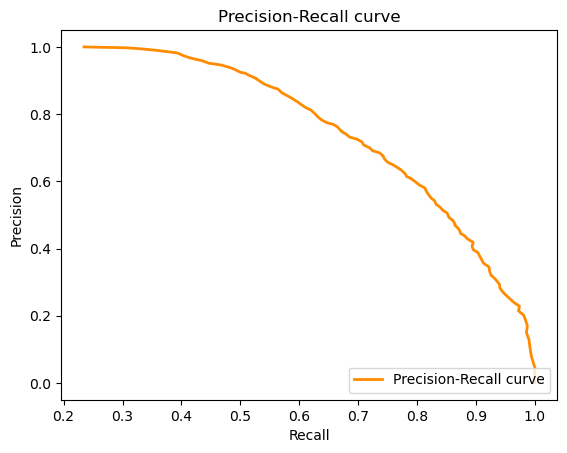

In [15]:
# plot precision-recall curves

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

plt.figure()
lw = 2
plt.plot(pr_data['precision'][0], pr_data['recall'][0], color='darkorange',
        lw=lw, label='Precision-Recall curve')
# plt.plot(pr_data['precision'][0], pr_data['thresholds'][0], color='darkblue',
#         lw=lw, label='Thresholds')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
#plot auc curve

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
plt.switch_backend('agg')

# output_mapping = clfutil.get_output_mapping()
# get key corresponding to value 1

# pos_label = list(output_mapping.keys())[list(output_mapping.values()).index(1)]

fpr, tpr, thresholds = auc_data['fpr'][0], auc_data['tpr'][0], auc_data['thresholds'][0]
roc_auc = auc_data['auc'][0]

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.savefig('roc_curve.png')
plt.show()

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
from statsmodels.stats.outliers_influence import OLSInfluence
import pandas as pd
import joblib
import os
import sys 
project_path = os.getenv('PROJECT_PATH')
sys.path.append(project_path)
sys.path.append('../Enums/')
# from Enums.enums import RegressionMetrics
from enum import Enum
class RegressionMetrics(Enum):
    R2 = "R2 Score"
    MAE = "Mean Absolute Error"
    MSE = "Mean Squared Error"
    RMSE = "Root Mean Squared Error"

import warnings
warnings.filterwarnings("ignore")

class RegressionUtility():
    def __init__(self, data, target_column, metric_type=RegressionMetrics.R2.value):
        self.data = data
        self.target_column = target_column
        self.cardinality_threshold = 10
        self.metric_type = metric_type
        self.classifiers = [
            Ridge(alpha=0.5),
            BayesianRidge(),
            RandomForestRegressor(),
            AdaBoostRegressor()
        ]

    def get_numerical_columns(self):
        numerical_columns = []
        for column in self.data.columns:
            if column != self.target_column and (self.data[column].dtype == 'int64' or self.data[column].dtype == 'float64'):
                numerical_columns.append(column)
        self.numerical_columns = numerical_columns
        # return numerical_columns
    
    def get_categorical_columns(self):
        categorical_columns = []
        for column in self.data.columns:
            if self.data[column].dtype == 'object':
                categorical_columns.append(column)
        self.categorical_columns = categorical_columns
        # return categorical_columns

    def get_categorical_column_cardinality(self):
        cardinality = {}
        for column in self.categorical_columns:
            cardinality[column] = len(self.data[column].unique())
        self.cardinality = cardinality

    def get_target_encoding_columns(self):
        target_encoding_columns = []
        for column in self.categorical_columns:
            if column != self.target_column and  self.cardinality[column] > self.cardinality_threshold:
                target_encoding_columns.append(column)
        self.target_encoding_columns = target_encoding_columns
    
    def get_one_hot_encoding_columns(self):
        one_hot_encoding_columns = []
        for column in self.categorical_columns:
            if column != self.target_column and self.cardinality[column] <= self.cardinality_threshold:
                one_hot_encoding_columns.append(column)
        self.one_hot_encoding_columns = one_hot_encoding_columns

    def split_data(self):
        X = self.data.drop(self.target_column, axis=1)
        y = self.data[self.target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def prepare_data(self):
        self.get_numerical_columns()
        self.get_categorical_columns()
        self.get_categorical_column_cardinality()
        self.get_target_encoding_columns()
        self.split_data()
        self.get_one_hot_encoding_columns()

    def get_preprocessor(self):
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        target_categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('target', TargetEncoder())
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('numerical', numerical_transformer, self.numerical_columns),
                ('one_hot_encoding', categorical_transformer, self.one_hot_encoding_columns),
                ('target_encoding', target_categorical_transformer, self.target_encoding_columns)
            ]
        )

        self.preprocessor = preprocessor
    
    def get_estimator(self, estimator):

        estimator = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('regressor', estimator)
        ])
        self.estimator = estimator
    
    def trainAutoML(self):
        self.prepare_data()
        self.get_preprocessor()
        print("Status: Setting up AutoML Training", file=sys.stderr)

        results = []
        trained_models = {}

        pbar = tqdm(self.classifiers)
        for classifier in pbar:
            self.get_estimator(classifier)
            
            pbar.set_description("Status: %s Current Classifier: %s Processing" % ('Training', classifier.__class__.__name__))

            self.estimator.fit(self.X_train, self.y_train)
            trained_models[classifier.__class__.__name__] = self.estimator

            y_pred = self.estimator.predict(self.X_test)
            # print(y_pred)

            r2 = r2_score(self.y_test, y_pred)
            mse = mean_squared_error(self.y_test, y_pred)
            mae = mean_absolute_error(self.y_test, y_pred)
            rmse = mean_squared_error(self.y_test, y_pred, squared=False)

            results.append({
                'Classifier' : classifier.__class__.__name__,
                RegressionMetrics.R2.value : round(r2, 2),
                RegressionMetrics.MSE.value : round(mse, 2),
                RegressionMetrics.MAE.value : round(mae, 2),
                RegressionMetrics.RMSE.value : round(rmse, 2)
            })
        
        self.trained_models = trained_models
        self.results = pd.DataFrame(results)
        self.getBestModel(self.metric_type)

    def getBestModel(self, metric):
        self.results.sort_values(by=metric, ascending=False, inplace=True)
        self.best_model = self.results.iloc[0]
        self.best_estimator = self.trained_models[self.best_model['Classifier']]
        return self.best_model
    
    def saveModel(self, model_name, save_path):
        joblib.dump(self.trained_models[model_name], save_path)
        self.save_path = save_path
    
    def get_input_schema(self):
        self.input_schema = []
        for column in self.data.columns:
            if column != self.target_column:
                self.input_schema.append({
                    'column_name' : column,
                    'column_type' : self.data[column].dtype.name
                })
        return self.input_schema
    
    def get_output_schema(self):
        self.output_schema = []
        self.output_schema.append({
            'column_name' : self.target_column,
            'column_type' : self.data[self.target_column].dtype.name
        })
        return self.output_schema
    
    def get_output_mapping(self):
        self.output_mapping = {}
        return self.output_mapping

    def get_feature_importance(self):
        feature_importance = {}
        feature_importance['feature_names'] = self.X_train.columns.tolist()
        feature_importance['feature_importance'] = permutation_importance(self.best_estimator, self.X_test, self.y_test, n_repeats=3, random_state=42)['importances_mean'].tolist()
        return feature_importance
    
    def get_scatter_plot_data(self):
        scatter_plot_data = {}
        scatter_plot_data['y_true'] = self.y_test.tolist()
        scatter_plot_data['y_pred'] = self.best_estimator.predict(self.X_test).tolist()
        return scatter_plot_data

    def get_residual_plot_data(self):
        residual_plot_data = {}
        residual_plot_data['y_pred'] = self.best_estimator.predict(self.X_test).tolist()
        residual_plot_data['residuals'] = (self.best_estimator.predict(self.X_test) - self.y_test).tolist()
        return residual_plot_data
    
    def get_cooks_distance_data(self):
        regressor = self.best_estimator.named_steps['regressor']
        cooks_distance_data = {}
        cooks_distance_data['x'] = list(range(len(self.X_test)))
        cooks_distance_data['y'] = OLSInfluence(regressor).cooks_distance[0].tolist()
        return cooks_distance_data

In [48]:
data = pd.read_csv('../Datasets/51182.csv')
target_column = 'Weekly_Sales'
reg_util = RegressionUtility(data, target_column)

In [49]:
reg_util.trainAutoML()

Status: Setting up AutoML Training
Status: Training Current Classifier: BayesianRidge Processing:  25%|██▌       | 1/4 [00:00<00:00,  7.41it/s]

Status: Training Current Classifier: AdaBoostRegressor Processing: 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]    


In [35]:
fi = reg_util.get_feature_importance()

In [36]:
print(fi)

{'feature_names': ['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], 'feature_importance': [1.7166392375275246, 0.08333023643625721, -9.728671697473157e-05, 0.012868375710693694, 0.008195576078779557, 0.9302109857759442, 0.1220995346093442]}


In [37]:
scatter_plot_data = reg_util.get_scatter_plot_data()

In [51]:
print(scatter_plot_data)

{'y_true': [1138800.32, 1304850.67, 1769296.25, 1077640.13, 428851.99, 1004523.59, 1523410.71, 1014898.78, 1955896.59, 958667.23, 687344.68, 513991.57, 1840686.94, 881503.95, 955506.95, 874790.68, 672194.03, 820964.1, 608390.94, 547384.9, 733564.77, 457711.68, 2102530.17, 875372.91, 981345.2, 1999794.26, 2495630.51, 2461468.35, 620087.35, 1509323.09, 1033552.18, 1375458.21, 1686010.02, 1394065.76, 1379488.05, 611258.71, 1933719.21, 1912791.09, 2427640.17, 1837743.6, 808821.5, 773878.58, 1153332.89, 1244390.03, 1285358.01, 895069.88, 1507460.69, 481119.6, 2042581.71, 469598.57, 2057059.53, 1833511.08, 1725268.56, 1063557.49, 1837553.43, 412314.71, 1495536.46, 873643.14, 457216.87, 935266.43, 1530761.43, 922539.94, 1124763.74, 386344.54, 275313.34, 224294.39, 697645.32, 450756.71, 2091663.2, 537224.52, 246124.61, 767338.32, 1448938.92, 1911967.44, 941612.04, 555279.02, 432808.48, 656637.63, 579874.22, 387944.83, 1249696.97, 292859.36, 994801.4, 494145.8, 412456.48, 280472.78, 496851.6, 8

In [41]:
y_true = scatter_plot_data['y_true']
y_pred = scatter_plot_data['y_pred']

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
plt.switch_backend('agg')

plt.figure()
lw = 2
plt.scatter(y_true, y_pred, color='darkorange',
        lw=lw, label='Scatter Plot')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot')
plt.legend(loc="lower right")
plt.savefig('scatter_plot.png')
plt.show()

In [42]:
residual_plot_data = reg_util.get_residual_plot_data()

In [53]:
print(residual_plot_data)

{'y_true': [1138800.32, 1304850.67, 1769296.25, 1077640.13, 428851.99, 1004523.59, 1523410.71, 1014898.78, 1955896.59, 958667.23, 687344.68, 513991.57, 1840686.94, 881503.95, 955506.95, 874790.68, 672194.03, 820964.1, 608390.94, 547384.9, 733564.77, 457711.68, 2102530.17, 875372.91, 981345.2, 1999794.26, 2495630.51, 2461468.35, 620087.35, 1509323.09, 1033552.18, 1375458.21, 1686010.02, 1394065.76, 1379488.05, 611258.71, 1933719.21, 1912791.09, 2427640.17, 1837743.6, 808821.5, 773878.58, 1153332.89, 1244390.03, 1285358.01, 895069.88, 1507460.69, 481119.6, 2042581.71, 469598.57, 2057059.53, 1833511.08, 1725268.56, 1063557.49, 1837553.43, 412314.71, 1495536.46, 873643.14, 457216.87, 935266.43, 1530761.43, 922539.94, 1124763.74, 386344.54, 275313.34, 224294.39, 697645.32, 450756.71, 2091663.2, 537224.52, 246124.61, 767338.32, 1448938.92, 1911967.44, 941612.04, 555279.02, 432808.48, 656637.63, 579874.22, 387944.83, 1249696.97, 292859.36, 994801.4, 494145.8, 412456.48, 280472.78, 496851.6, 8

In [45]:
y_true = residual_plot_data['y_true']
residuals = residual_plot_data['residuals']

import matplotlib.pyplot as plt

# Assuming you have a fitted model 'model' and residuals 'residuals'
# For example:
# model = sm.OLS(y, X).fit()

# Create a histogram of residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.75)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Histogram")

# Create a density plot (kernel density estimation) of residuals
plt.subplot(1, 2, 2)
plt.plot(residuals, '.', markersize=3, label='Residuals', alpha=0.5)
plt.xlabel("Observation Index")
plt.ylabel("Residuals")
plt.title("Residual Density Plot")

plt.tight_layout()
plt.savefig('residual_plot.png')
plt.show()


In [50]:
cooks_distance_data = reg_util.get_cooks_distance_data()

AttributeError: 'RandomForestRegressor' object has no attribute 'model'